In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Alzheimers disease.zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os, zipfile

# Extract the zip file
with zipfile.ZipFile("/content/Alzheimers disease.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Alzheimers_disease")  # Extract to a directory

# Now list the contents of the extracted directory
total_classes = os.listdir("/content/Alzheimers_disease")
print(total_classes)

['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']


In [4]:
# Total number of images per class.
images_path = Path("/content/Alzheimers_disease")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Non_Demented = 3200 images
* Very_Mild_Demented = 2240 images
* Mild_Demented = 896 images
* Moderate_Demented = 64 images


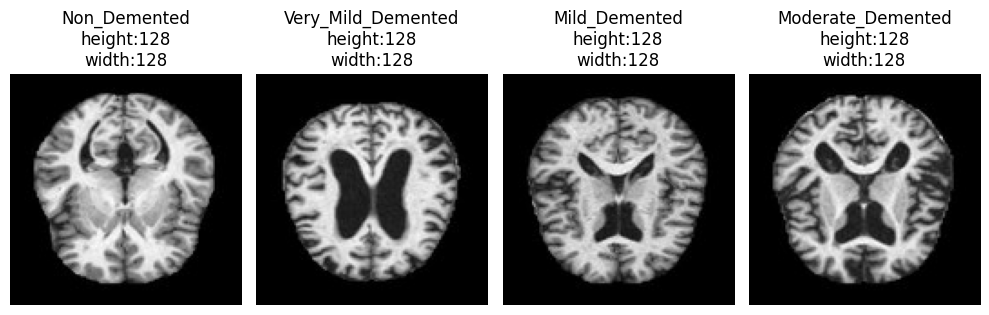

In [5]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


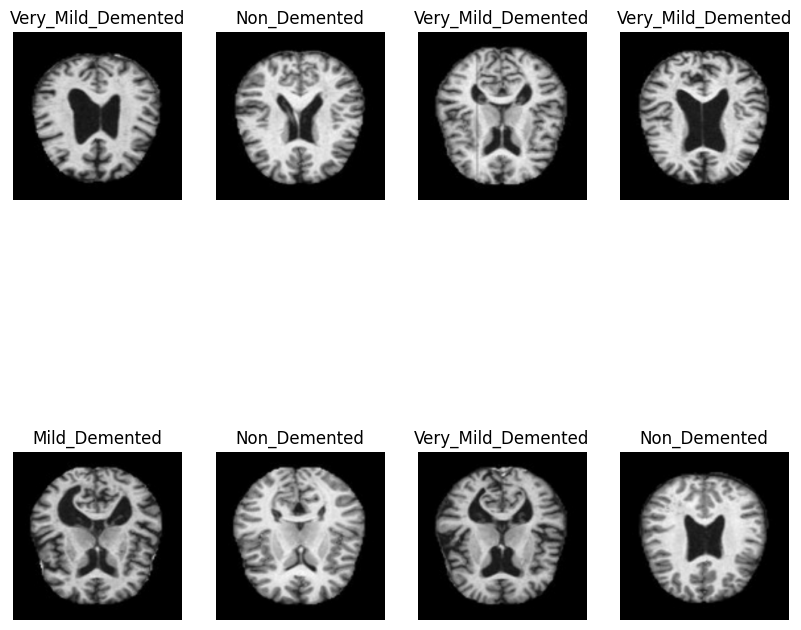

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardizing the dataset**

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.99437773


**Import ResNet50**

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Number of output classes
num_classes = len(class_names)

# Load the ResNet50 model without the top layers
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units and activation function as needed
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 25,636,868 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

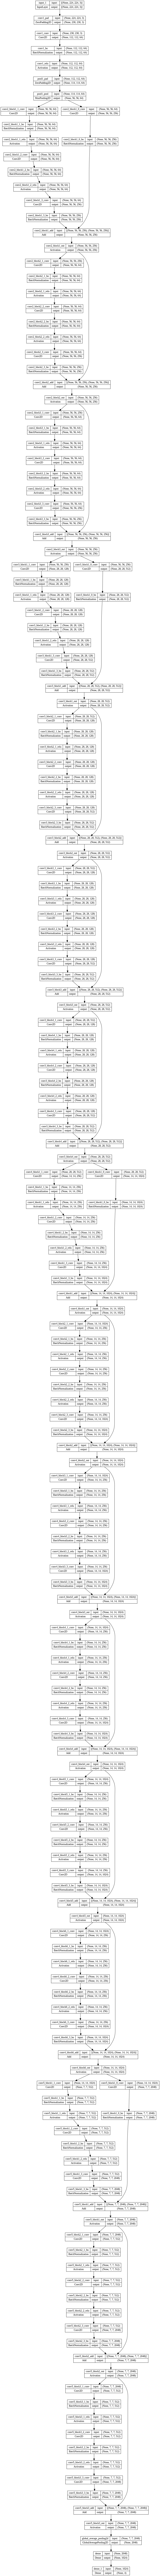

In [ ]:
from tensorflow.keras.utils import plot_model
# Save the model summary as an image
plot_model(model, to_file='ResNet50_model_summary_before_Data_Aug.png', show_shapes=True, show_layer_names=True)

In [24]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 300ms/step - accuracy: 0.9430 - loss: 0.1524 - val_accuracy: 0.3516 - val_loss: 7.3675
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 85s 321ms/step - accuracy: 0.9595 - loss: 0.1224 - val_accuracy: 0.6664 - val_loss: 2.2164
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 51s 317ms/step - accuracy: 0.9687 - loss: 0.0891 - val_accuracy: 0.6211 - val_loss: 1.2834
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - accuracy: 0.9830 - loss: 0.0531 - val_accuracy: 0.8562 - val_loss: 0.7365
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 51s 317ms/step - accuracy: 0.9864 - loss: 0.0431 - val_accuracy: 0.5320 - val_loss: 2.9489
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - accuracy: 0.9854 - loss: 0.0449 - val_accuracy: 0.8687 - val_loss: 0.5129
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - accuracy: 0.9883 - loss: 0.0349 - val_accuracy: 0.8867 - val_loss: 0.4015
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 322ms/step - accuracy: 0.9904 -

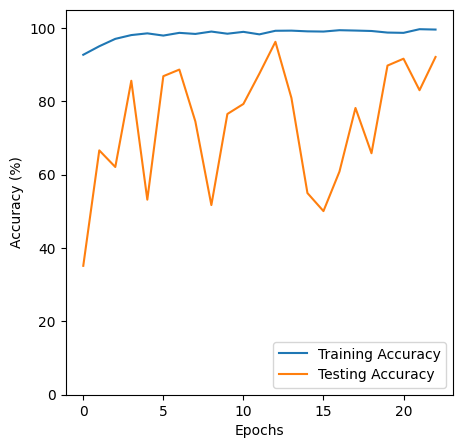

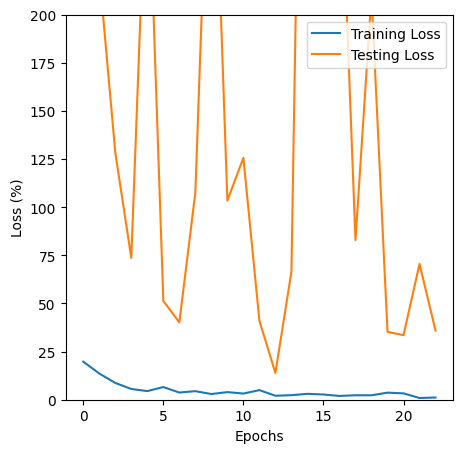

In [26]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
#plt.title("Training and Validation Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('ResNet50_100_training_testing_accuracy_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([0, 200])
# Save the loss plot
plt.savefig('ResNet50_100_training_testing_loss_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step


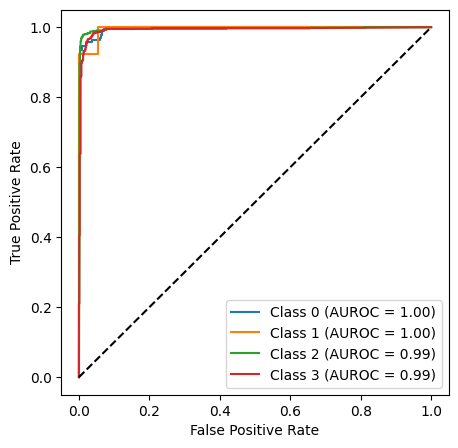

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_logits = model.predict(val_ds)
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()  # Convert logits to probabilities
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # True labels for the validation set

# If it's a multi-class problem, binarize the labels for AUROC calculation
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Create a single figure for plotting all ROC curves
plt.figure(figsize=(5, 5))

# Calculate AUROC for each class and plot
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUROC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the combined plot with all ROC curves
plt.savefig('ResNet50_100_AUROC_before_Data_Aug.png')
plt.show()


In [28]:
model.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9678 - loss: 0.1218


[0.1387476623058319, 0.9624999761581421]

In [29]:
model.evaluate(train_ds)

160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9917 - loss: 0.0251


[0.026790544390678406, 0.9906250238418579]

**Augmentation**

In [30]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

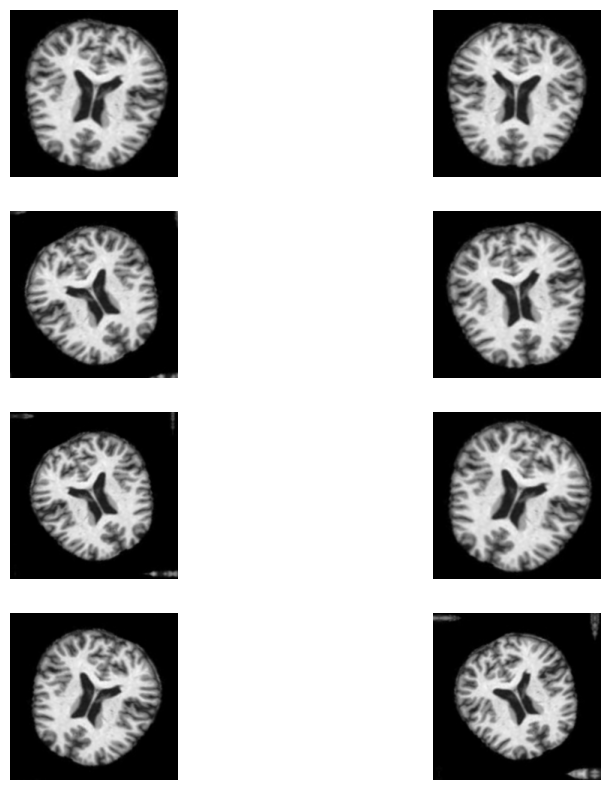

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Add a drop-out layer**

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Number of output classes
num_classes = len(class_names)

# Load the ResNet50 model without the top layers
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units and activation function as needed
x = Dropout(0.2)(x)  # Adding Dropout layer with 20% rate
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [33]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [34]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 25,636,868 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

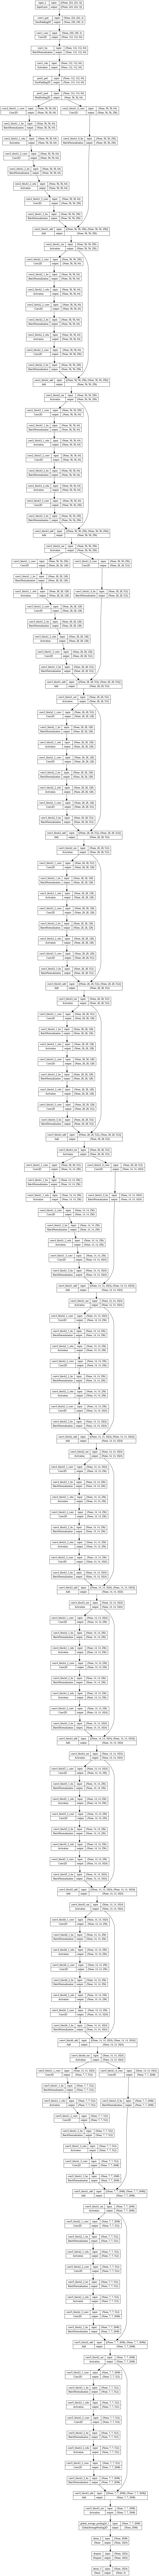

In [ ]:
from tensorflow.keras.utils import plot_model
# Save the model summary as an image
plot_model(model, to_file='ResNet50_model_summary_after_Data_Aug.png', show_shapes=True, show_layer_names=True)

In [35]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 348ms/step - accuracy: 0.5238 - loss: 1.3217 - val_accuracy: 0.6062 - val_loss: 1.2231
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 332ms/step - accuracy: 0.6565 - loss: 0.7489 - val_accuracy: 0.1328 - val_loss: 6.1346
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 52s 324ms/step - accuracy: 0.7945 - loss: 0.5168 - val_accuracy: 0.5297 - val_loss: 5.8572
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.8876 - loss: 0.2926 - val_accuracy: 0.6187 - val_loss: 1.4016
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 330ms/step - accuracy: 0.9433 - loss: 0.1595 - val_accuracy: 0.3703 - val_loss: 6.2832
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.9543 - loss: 0.1223 - val_accuracy: 0.8328 - val_loss: 0.5969
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 53s 330ms/step - accuracy: 0.9798 - loss: 0.0628 - val_accuracy: 0.7422 - val_loss: 0.9762
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.9795 

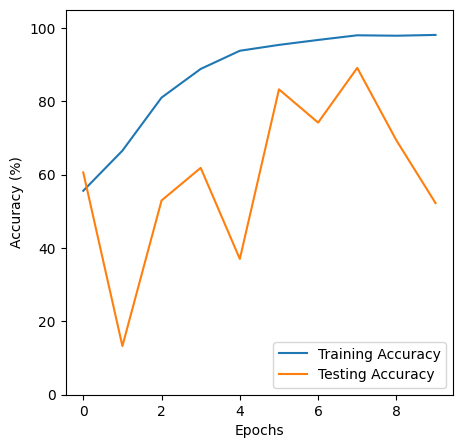

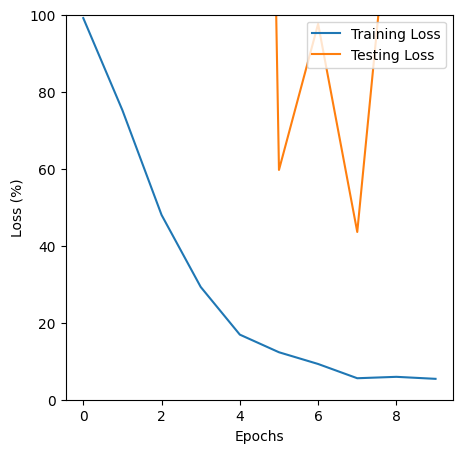

In [40]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
#plt.title("Training and Validation Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('ResNet50_100_training_testing_accuracy_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([0, 100])
# Save the loss plot
plt.savefig('ResNet50_100_training_testing_loss_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step


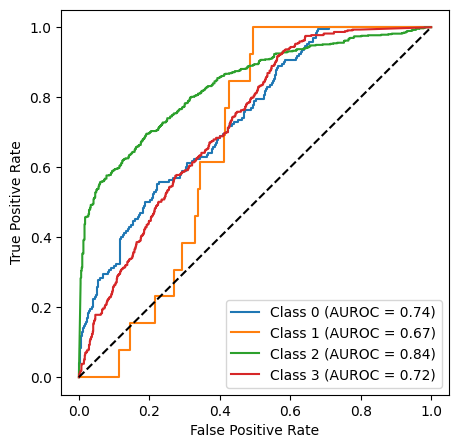

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_logits = model.predict(val_ds)
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()  # Convert logits to probabilities
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # True labels for the validation set

# If it's a multi-class problem, binarize the labels for AUROC calculation
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Create a single figure for plotting all ROC curves
plt.figure(figsize=(5, 5))

# Calculate AUROC for each class and plot
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUROC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the combined plot with all ROC curves
plt.savefig('ResNet50_100_AUROC_after_Data_Aug.png')
plt.show()


In [38]:
model.evaluate(train_ds)

160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.6049 - loss: 1.2044


[1.1961312294006348, 0.610156238079071]

In [39]:
model.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6018 - loss: 1.2279


[1.2231398820877075, 0.606249988079071]

In [ ]:
# Save the Keras model as an HDF5 file
model.save("ResNet50_100_alzeihmer_model_new.h5")